# Set-up

In [1]:
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import surrojax_gp
import os
import sys
sys.path.insert(0, '..')
import plotting_helpers

Plotting settings:

In [2]:
# dpi of images displayed in notebook:
mpl.rcParams['figure.dpi'] = 200

Create directory to save figures:

In [3]:
fig_save_dir = './figs/gp'
if not os.path.isdir(fig_save_dir):
    os.mkdir(fig_save_dir)

Plotting function:

In [4]:
def plot_surface(x, y, z, z_lims=None, num_x_ticks=10, num_y_ticks=10, 
                 num_z_ticks=10, z_ticks_dp=1, train_pts=None, z_label=None):
    if z_label is None:
        z_label = '$z$'
    fig, ax = plt.subplots()
    if z_lims is None:
        z_lims = (jnp.min(z), jnp.max(z))
    im = plt.imshow(z, cmap='coolwarm', origin='lower', vmin=z_lims[0], vmax=z_lims[1])
    plotting_helpers.set_x_and_y_ticks(ax, x, y, num_x_ticks, num_y_ticks)
    plotting_helpers.create_colourbar(im, z_label, z_lims, num_z_ticks, z_ticks_dp)
    if train_pts is not None:
        plot_pts = {}
        for i in (0, 1):
            plot_pts[i] = x.shape[i]*(train_pts[i] - jnp.min(train_pts[i]))/(jnp.max(train_pts[i]) - jnp.min(train_pts[i]))
        plt.plot(plot_pts[0].squeeze(), plot_pts[1].squeeze(), 'x', color='black', markersize=5)
        ax.set_xlim(jnp.min(plot_pts[0]), jnp.max(plot_pts[0]))
        ax.set_ylim(jnp.min(plot_pts[1]), jnp.max(plot_pts[1]))
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    plotting_helpers.clean_up_plot(fig)

Function to differentiate and vmap:

In [5]:
def grad_and_vmap(func, args):
    grad = func
    for arg in args:
        grad = jax.jacfwd(grad, argnums=arg)
    for _ in range(2):
        grad = jax.vmap(grad, in_axes=(0,0))
    return grad    

# Verification

Function to learn:

In [6]:
# Peak function (see: https://mathworks.com/help/matlab/ref/peaks.html)
def peaks(x, y):
    first_term = 3*(1-x)**2*jnp.exp(-x**2-(y+1)**2)
    second_term = -10*(x/5 - x**3 - y**5)*jnp.exp(-x**2-y**2)
    third_term = -1/3*jnp.exp(-(x+1)**2-y**2)
    return first_term + second_term + third_term

Kernel:

In [7]:
def kernel(x_1, x_2, params):
    lengths = jnp.array([params[f"length_{i}"] for i in range(2)])
    inv_lengths = jnp.diag(lengths**(-1))
    ln_k_d = -0.5*(x_1 - x_2).T @ inv_lengths @ (x_1 - x_2) 
    return params["const"]*jnp.exp(ln_k_d)

Define training data points

In [8]:
num_train_pts = 10
x_vals = jnp.linspace(-3, 3, num_train_pts)
y_vals = jnp.linspace(-3, 3, num_train_pts)
x_train, y_train = jnp.meshgrid(x_vals, y_vals)

Plot 'true' function:

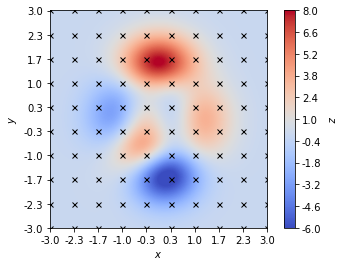

In [9]:
num_pts = 1000
x_vals = jnp.linspace(-3, 3, num_pts)
y_vals = jnp.linspace(-3, 3, num_pts)
x, y = jnp.meshgrid(x_vals, y_vals)
z = peaks(x,y)
plot_surface(x, y, z, z_lims=(-6,8), train_pts=[x_train,y_train])
plt.savefig(os.path.join(fig_save_dir, 'original_peaks.svg'))

Create 'training' data:

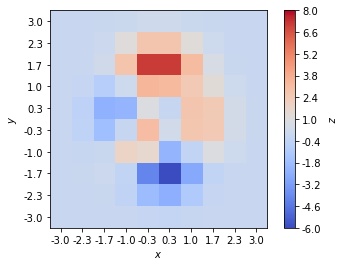

In [10]:
z_train = peaks(x_train,y_train)
plot_surface(x_train, y_train, z_train, z_lims=(-6,8))
plt.savefig(os.path.join(fig_save_dir, 'training_peaks.svg'))

Train GP:

In [11]:
constraints = {"length_0": {">": 0.01, "<": 10}, 
               "length_1": {">": 0.01, "<": 10}, 
               "const": {">": 0.01, "<": 10}}
train_features = jnp.stack([x_train.flatten(), y_train.flatten()], axis=1)
train_labels = z_train.flatten()
gp = surrojax_gp.create_gp(kernel, train_features, train_labels, constraints)

1381319.4
1482600.9
742927.7
474495.5
679.0415
667.0041
627.3411
490.9471
331.29828
282.24457
197.47028
174.9865
174.85986
174.80753
174.79156
174.73648
174.22098
163.89136
194.13953
145.76044
144.56006
155573.5
168.5094
143.40848
144410.08
272.28546
127.1215
122.05151
120.66092
120.43143
120.27492
120.06927
119.922745
119.91484
119.8902
119.89017
119.8905
119.89046
119.89017
119.89017
119.890274
119.89017
119.89017
119.89017
119.89017
119.89017
      fun: 119.89016723632812
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00403214,  0.01280212, -0.01596832])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 46
      nit: 24
     njev: 46
   status: 0
  success: True
        x: array([3.20540209, 0.54046134, 0.55210681])
931416.75
222.28546
222.28525
222.28436
222.28079
222.26657
222.20966
221.9674
218.89276
188.44781
2018.4409
151.13092
147.8961
147.33385
2383612400.0
439576.38
147.33331
147.33319
78852.16
368.07315
147.48282
147.32167

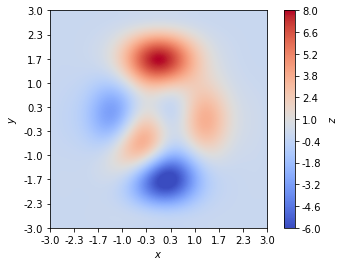

In [12]:
features = jnp.stack([x.flatten(), y.flatten()], axis=1)
gp_vals = gp.predict(features)['mean'].reshape(num_pts,num_pts)
plot_surface(x, y, gp_vals, z_lims=(-6,8))
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks.svg'))

# Gradient Predictions

In [13]:
features = jnp.stack([x.flatten(), y.flatten()], axis=1)

Gradient wrt x:

In [14]:
gp_dx = gp.predict(features, grad=({'idx':[0], 'order':1},))['mean'].reshape(num_pts,num_pts)
true_dx = grad_and_vmap(peaks, args=(0,))(x,y).reshape(num_pts,num_pts)

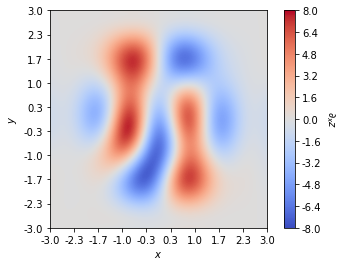

In [15]:
plot_surface(x, y, gp_dx, z_lims=(-8,8), z_label='$\partial_x z$')
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks_dx.svg'))

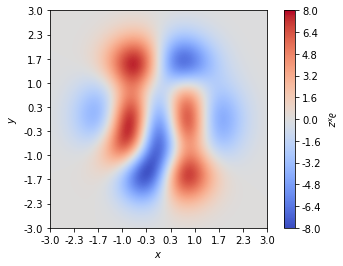

In [16]:
plot_surface(x, y, true_dx, z_lims=(-8,8), z_label='$\partial_x z$')
plt.savefig(os.path.join(fig_save_dir, 'true_peaks_dx.svg'))

Gradient wrt y:

In [17]:
gp_dy = gp.predict(features, grad=({'idx':[1], 'order':1},))['mean'].reshape(num_pts,num_pts)
true_dy = grad_and_vmap(peaks, args=(1,))(x,y).reshape(num_pts,num_pts)

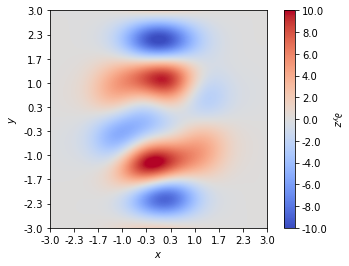

In [18]:
plot_surface(x, y, gp_dy, z_lims=(-10,10), z_label='$\partial_y z$')
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks_dy.svg'))

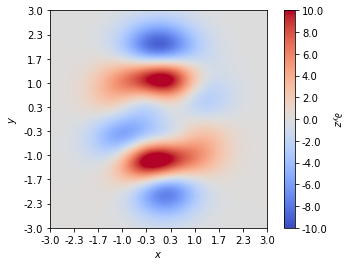

In [19]:
plot_surface(x, y, true_dy, z_lims=(-10,10), z_label='$\partial_y z$')
plt.savefig(os.path.join(fig_save_dir, 'true_peaks_dy.svg'))

Mixed gradient wrt x and y:

In [20]:
gp_dxdy = gp.predict(features, grad=({'idx':[0], 'order':1},{'idx':[1], 'order':1}))['mean'].reshape(num_pts,num_pts)
true_dxdy = grad_and_vmap(peaks, args=(0,1))(x,y).reshape(num_pts,num_pts)

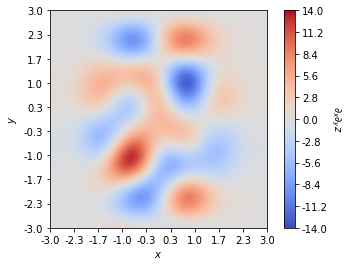

In [21]:
plot_surface(x, y, gp_dxdy, z_lims=(-14,14), z_label='$\partial_x \partial_y z$')
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks_dxdy.svg'))

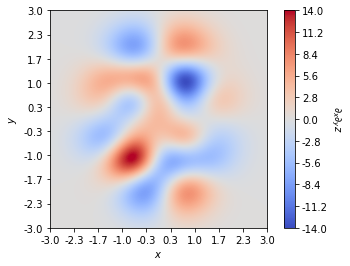

In [22]:
plot_surface(x, y, true_dxdy, z_lims=(-14,14), z_label='$\partial_x \partial_y z$')
plt.savefig(os.path.join(fig_save_dir, 'true_peaks_dxdy.svg'))

Double gradient wrt x:

In [23]:
gp_dxdx = gp.predict(features, grad=({'idx':[0], 'order':1},{'idx':[0], 'order':1}))['mean'].reshape(num_pts,num_pts)
true_dxdx = grad_and_vmap(peaks, args=(0,0))(x,y).reshape(num_pts,num_pts)

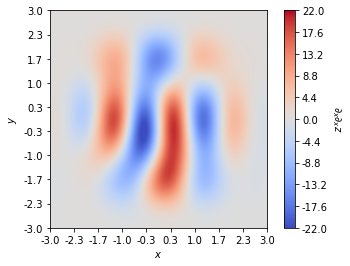

In [24]:
plot_surface(x, y, gp_dxdx, z_lims=(-22,22), z_label='$\partial_x \partial_x z$')
plt.savefig(os.path.join(fig_save_dir, 'pred_peaks_dxdx.svg'))

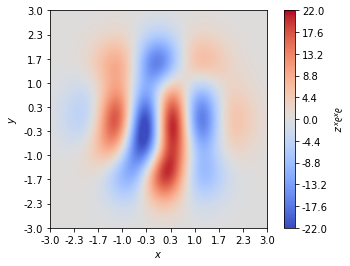

In [25]:
plot_surface(x, y, true_dxdx, z_lims=(-22,22), z_label='$\partial_x \partial_x z$')
plt.savefig(os.path.join(fig_save_dir, 'true_peaks_dxdx.svg'))